# Getting Started with FLORIS v3

FLORIS is a command-line program written in Python. There are two primary packages that make up the software:
- `floris.simulation`: simulation framework including wake model definitions
- `floris.tools`: utilities for pre and post processing as well as driving the simulation

Users of FLORIS will develop a Python script with the following sequence of steps:

1. preprocess
2. calculation
3. postprocess

Generally, users will only interact with `floris.tools` and most often through the `FlorisInterface` class. Additionally, `floris.tools` contains functionality for comparing results, creating visualizations, and developing optimization cases. 

**NOTE `floris.tools` is under active design and development. The API's will change and additional functionality from FLORIS v2 will be included in upcoming releases.**

This notebook steps through the basic ideas and operations of FLORIS while showing realistic uses and expected behavior.

## Initialize FlorisInterface

The `FlorisInterface` provides functionality to build a wind farm representation and drive the simulation. This object is created (instantiated) by passing the path to a FLORIS input file. Once this object is created, it can immediately be used to inspect the data.

In [1]:
import numpy as np
from floris.tools import FlorisInterface

fi = FlorisInterface("inputs/gch.yaml")
x, y = fi.get_turbine_layout()

print("     x       y")
for _x, _y in zip(x, y):
    print(f"{_x:6.1f}, {_y:6.1f}")

     x       y
   0.0,    0.0
 630.0,    0.0
1260.0,    0.0


## Build the model

At this point, FLORIS has been initialized with the data defined in the input file. However, it is often simpler to define a basic configuration in the input file as a starting point and then make modifications in the Python script.
This allows for generating data algorithmically or loading data from a data file. Modifications to the wind farm representation are handled through the `FlorisInterface.reinitialize()` function with keyword arguments. Another way to
think of this function is that it changes the value of inputs specified in the input file.

Let's change the location of turbines in the wind farm.

In [2]:
# Design a wind farm with turbines in a 2x2 pattern
# Units are in meters
x_2x2 = [0, 0, 800, 800]
y_2x2 = [0, 400, 0, 400]
fi.reinitialize( layout=(x_2x2, y_2x2) )

x, y = fi.get_turbine_layout()

print("     x       y")
for _x, _y in zip(x, y):
    print(f"{_x:6.1f}, {_y:6.1f}")

     x       y
   0.0,    0.0
   0.0,  400.0
 800.0,    0.0
 800.0,  400.0


Additionally, we can change the wind speeds and wind directions. These are given as lists of wind speeds and wind directions that will be
expanded so that a wake calculation will happen for every wind direction with each speed.

Notice that we can give `FlorisInterface.reinitialize()` multiple keyword arguments at once.

In [3]:
# One wind direction and one speed -> one atmospheric condition
fi.reinitialize( wind_directions=[270.0], wind_speeds=[8.0] )

# Two wind directions and one speed -> two atmospheric conditions
fi.reinitialize( wind_directions=[270.0, 280.0], wind_speeds=[8.0] )

# Two wind directions and two speeds -> four atmospheric conditions
fi.reinitialize( wind_directions=[270.0, 280.0], wind_speeds=[8.0, 9.0] )

`FlorisInterface.reinitialize()` creates all of the basic data structures required for the simulation but it does not do any aerodynamic calculations.
The low level data structures have a complex shape that enables faster computations. Specifically, most data is structured as a many-dimensional Numpy array
with the following dimensions:

- 0: wind directions
- 1: wind speeds
- 2: turbines
- 3: grid-1
- 4: grid-2

For example, we can see the overall shape of the data structure for the grid point x-coordinates for the all turbines and get the x-coordinates of grid points for the
third turbine in the first wind direction and first wind speed. We can also plot all the grid points in space to get an idea of the overall form of our grid.

Dimensions of grid x-components
(2, 2, 4, 3, 3)

Turbine 3 grid x-components for first wind direction and first wind speed
[[800. 800. 800.]
 [800. 800. 800.]
 [800. 800. 800.]]


(0.0, 150.0)

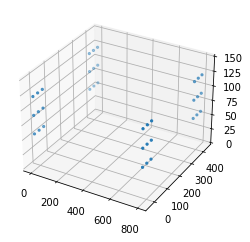

In [4]:
import numpy as np
import matplotlib.pyplot as plt

print("Dimensions of grid x-components")
print( np.shape(fi.floris.grid.x) )

print()
print("Turbine 3 grid x-components for first wind direction and first wind speed")
print(fi.floris.grid.x[0, 0, 2, :, :])

x = fi.floris.grid.x[0, 0, :, :, :]
y = fi.floris.grid.y[0, 0, :, :, :]
z = fi.floris.grid.z[0, 0, :, :, :]

# TODO
# circle = plt.Circle((np.mean(ys_turbine_0), fi.floris.turbine.hub_height), fi.floris.turbine.rotor_diameter / 2.0, color='r', fill=False)
# ax.add_patch(circle)
# ax.set_aspect('equal')
# ax.grid(True)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, marker=".")
ax.set_zlim([0, 150])

## Execute wake calculation

Running the wake calculation is a one-liner. This will calculate the velocities at each turbine given the wake of other turbines for every wind speed and wind direction combination.
Since we have not explicitly specified yaw control settings, all turbines are aligned with the inflow.

In [5]:
fi.calculate_wake()

## Get turbine power

At this point, the simulation has completed and we can use the `FlorisInterface` to extract useful information such as the power produced at each turbine. Remember that we have configured the simulation with two wind directions, two wind speeds, and four turbines.

In [6]:
powers = fi.get_turbine_powers() / 1000.0  # calculated in Watts, so convert to kW

print("Dimensions of `powers`")
print( np.shape(powers) )

print()
# TODO hold wind direction fixed and loop over wind speeds
print("Turbine powers for 8 m/s")
for i in range(2):
    print(f"Wind direction {i}")
    print(powers[i, 0, :])

# TODO: maybe describe get_farm_power() here?

print()
print("Turbine powers for all turbines at all wind conditions")
print(powers)


Dimensions of `powers`
(2, 2, 4)

Turbine powers for 8 m/s
Wind direction 0
[1691.32648289 1691.32648289  592.65288889  592.97819946]
Wind direction 1
[1691.32648289 1691.32648289 1631.06709246 1629.75508349]

Turbine powers for all turbines at all wind conditions
[[[1691.32648289 1691.32648289  592.65288889  592.97819946]
  [2407.84258855 2407.84258855  861.30598083  861.73203268]]

 [[1691.32648289 1691.32648289 1631.06709246 1629.75508349]
  [2407.84258855 2407.84258855 2321.41264704 2319.53233514]]]


## Applying yaw angles

Yaw angles are applied to turbines through the `FlorisInterface.calculate_wake` function.

**Note that `yaw_angles` is a array** -- You must provide yaw angles in a array with dimensions equal to:
- 0: number of wind directions
- 1: number of wind speeds
- 2: number of turbines

**Unlike data set in `FlorisInterface.reinitialize()`, yaw angles are not stored in memory and must be given again in successive calls to `FlorisInterface.calculate_wake`.**
**If no yaw angles are given, all turbines will be aligned with the inflow.**

In [7]:
# Array of zero yaw angles
yaw_angles = np.zeros( (2, 2, 4) )
print(yaw_angles)

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


In [8]:
# Yaw the front row for all wind directions and all wind speeds
yaw_angles = np.zeros( (2, 2, 4) )
yaw_angles[:, :, 0:2] = 25

# TODO Pass the settings to Floris
fi.calculate_wake( yaw_angles=yaw_angles )
print(yaw_angles)

[[[25. 25.  0.  0.]
  [25. 25.  0.  0.]]

 [[25. 25.  0.  0.]
  [25. 25.  0.  0.]]]


## Start to finish

Let's put it all together. The following code does the following:
1. Load an input file
2. Modify the inputs with a more complex wind turbine layout
3. Change the wind speeds and wind directions
4. Execute the simulation
5. Get the total farm power
6. Add yaw settings for some turbines
7. Execute the simulation
5. Get the total farm power and compare to without yaw control

In [9]:
from floris.tools import FlorisInterface

fi = FlorisInterface("inputs/gch.yaml")

# Construct the model
D = 126.0  # Design the layout based on turbine diameter
x = [0, 3 * D,  6 * D, 9 * D]
y = [0, 3 * D, -2 * D, 3 * D]
wind_directions = [210.0, 270.0]
wind_speeds = [8.0]

# Pass the new data to FlorisInterface
fi.reinitialize(
    layout=(x, y),
    wind_directions=wind_directions,
    wind_speeds=wind_speeds
)

# Calculate the velocities at each turbine for all atmospheric conditions with no yaw control settings
fi.calculate_wake()

# Get the farm power
turbine_powers = fi.get_turbine_powers() / 1000.0
farm_power_baseline = np.sum(turbine_powers, 2)

# Develop the yaw control settings
yaw_angles = np.zeros( (2, 1, 4) )  # Construct the yaw array with dimensions for two wind directions, one wind speed, and four turbines
yaw_angles[0, :, 0] = -5            # At 210 degrees, yaw the first turbine 10 degrees
yaw_angles[0, :, 1] = -20           # At 210 degrees, yaw the second turbine 10 degrees
yaw_angles[1, :, 1] = 20            # At 270 degrees, yaw the second turbine 10 degrees

# Calculate the velocities at each turbine for all atmospheric conditions given the yaw control settings
fi.calculate_wake( yaw_angles=yaw_angles )

# Get the farm power
turbine_powers = fi.get_turbine_powers() / 1000.0
farm_power_yaw = np.sum(turbine_powers, 2)

# Compare power difference with yaw
difference = 100 * (farm_power_yaw - farm_power_baseline) / farm_power_baseline
print("Power % difference with yaw")
print(f"    210 degrees: {difference[0, 0]:4.2f}%")
print(f"    270 degrees: {difference[1, 0]:4.2f}%")

Power % difference with yaw
    210 degrees: 3.95%
    270 degrees: 2.59%


## Visualization

While comparing turbine and farm powers is meaningful, a picture is worth at least 1000 Watts, and the `FlorisInterface` provides powerful routines for visualization.

**NOTE `floris.tools` is under active design and development. The API's will change and additional functionality from FLORIS v2 will be included in upcoming releases.**

The visualization functions require that the user select a single atmospheric condition to plot. However, the internal data structures still have the same shape but the wind speed and wind direction
dimensions have a size of 1. This means that the yaw angle array used for plotting must have the same shape as before but a single atmospheric condition must be selected.

Let's create a horizontal slice of each atmospheric condition from above with and without yaw settings included.


TODO point out that the farm is rotated relative to west - working on it
- north-fixed

TODO Describe yaw angle indexing

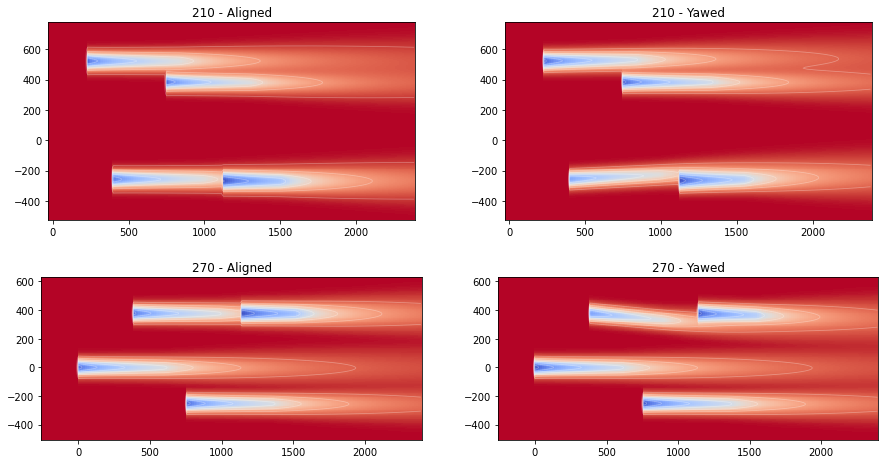

In [10]:
from floris.tools.visualization import visualize_cut_plane
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(2, 2, figsize=(15,8))

horizontal_plane = fi.calculate_horizontal_plane( wd=[210] )
visualize_cut_plane(horizontal_plane, ax=axarr[0,0], title="210 - Aligned")

horizontal_plane = fi.calculate_horizontal_plane( wd=[210], yaw_angles=yaw_angles[0:1,0:1] )
visualize_cut_plane(horizontal_plane, ax=axarr[0,1], title="210 - Yawed")

horizontal_plane = fi.calculate_horizontal_plane( wd=[270] )
visualize_cut_plane(horizontal_plane, ax=axarr[1,0], title="270 - Aligned")

horizontal_plane = fi.calculate_horizontal_plane( wd=[270], yaw_angles=yaw_angles[1:2,0:1] )
visualize_cut_plane(horizontal_plane, ax=axarr[1,1], title="270 - Yawed")

We can also create a visualization of the streamwise inflow velocities on the turbine rotor grid points located on the rotor plane.

Text(0.5, 0.98, 'Wind direction 270')

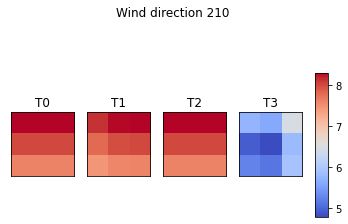

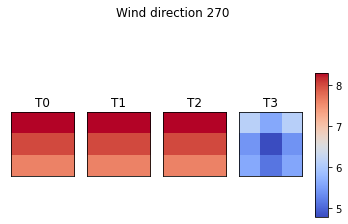

In [11]:
from floris.tools.visualization import plot_rotor_values

fig, _, _ , _ = plot_rotor_values(fi.floris.flow_field.u, wd_index=0, ws_index=0, n_rows=1, n_cols=4, return_fig_objects=True)
fig.suptitle("Wind direction 210")

fig, _, _ , _ = plot_rotor_values(fi.floris.flow_field.u, wd_index=1, ws_index=0, n_rows=1, n_cols=4, return_fig_objects=True)
fig.suptitle("Wind direction 270")

## On Grid Points

In FLORIS, grid points are the points in space where the wind conditions are calculated.  In a typical simulation, these are all located on a regular grid on each turbine rotor.

The parameter `turbine_grid_points` specifies the number of rows and columns which define the turbine grid.  In the default yaml input file this value is 3, meaning there are 3x3 = 9 total grid points.  Wake steering codes currently require greater values greater than 1 in order to compute gradients.  However, it is likely 1x1 is suitable for non wind farm control applications, although retuning of some parameters could be warranted.

We can visualize the locations of the grid points in the current example using pyplot:

xs has shape:  (2, 1, 4, 3, 3)  of 2 wd x 2 ws x 4 turbines x 3 x 3 grid points


(0.0, 150.0)

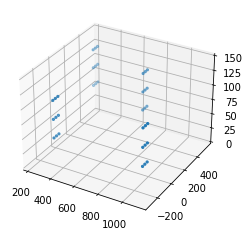

In [12]:
# Get the grid points
xs = fi.floris.grid.x
ys = fi.floris.grid.y
zs = fi.floris.grid.z

# Consider the shape
print('xs has shape: ', xs.shape, ' of 2 wd x 2 ws x 4 turbines x 3 x 3 grid points')

# Lets plot just one wd/ws conditions
xs = xs[0, 0, :, :, :]
ys = ys[0, 0, :, :, :]
zs = zs[0, 0, :, :, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs, ys, zs, marker=".")
ax.set_zlim([0, 150])

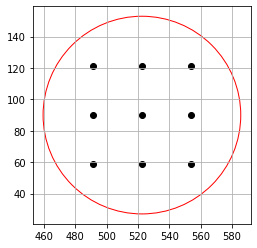

In [13]:
# Can further consider the points on just the 0th turbine
ys_turbine_0 = ys[0, :, :]
zs_turbine_0 = zs[0, :, :]

fig, ax = plt.subplots()
ax.scatter(ys_turbine_0, zs_turbine_0, color='k')

# Draw the rotor in the wind-direction rotated coordinate frame
circle = plt.Circle((np.mean(ys_turbine_0), fi.floris.turbine.hub_height), fi.floris.turbine.rotor_diameter / 2.0, color='r', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
ax.grid(True)

# Advanced Usage and Concepts

## Calculating AEP

Calculating AEP in FLORIS V3 takes advantage of the new vectorized framework to substantially reduce the computation time with respect to V2.4.

In these examples we demonstrate a simplied AEP calculation for a 25-turbine farm using several different modeling options.

We will make a simplifying assumption that every wind speed and direction is equally likely.

In [14]:
wind_directions = np.arange(0., 360., 5.)
wind_speeds = np.arange(5., 25., 1.)

num_wind_directions = len(wind_directions)
num_wind_speeds = len(wind_speeds)
num_bins = num_wind_directions * num_wind_speeds
print('Calculating AEP for %d wind direction and speed combinations...' % num_bins)

Calculating AEP for 1440 wind direction and speed combinations...


In [15]:
# Set up a square 25 turbine layout
N = 5  # Number of turbines per row and per column
D = 126. 

X, Y = np.meshgrid(
    7.0 * D * np.arange(0, N, 1),
    7.0 * D * np.arange(0, N, 1),
)
X = X.flatten()
Y = Y.flatten()
num_turbine = len(X)
print("Number of turbines = %d" % num_turbine)

Number of turbines = 25


In [16]:
# Define several models
fi_jensen = FlorisInterface("inputs/jensen.yaml")
fi_gch = FlorisInterface("inputs/gch.yaml")
fi_cc = FlorisInterface("inputs/cc.yaml")


In [17]:
# Assign the layouts, wind speeds and directions
fi_jensen.reinitialize(layout=(X, Y), wind_directions=wind_directions, wind_speeds=wind_speeds)
fi_gch.reinitialize(layout=(X, Y), wind_directions=wind_directions, wind_speeds=wind_speeds)
fi_cc.reinitialize(layout=(X, Y), wind_directions=wind_directions, wind_speeds=wind_speeds)

Calculate the AEP and use the jupyter time command to show computation time:

In [18]:
%%time
fi_jensen.calculate_wake()
jensen_aep = fi_jensen.get_farm_power().sum() / num_bins  / 1E9 * 365 * 24

CPU times: user 4.23 s, sys: 1.85 s, total: 6.08 s
Wall time: 5.18 s


In [19]:
%%time
fi_gch.calculate_wake()
gch_aep = fi_gch.get_farm_power().sum() / num_bins  / 1E9 * 365 * 24

CPU times: user 6.98 s, sys: 2.95 s, total: 9.93 s
Wall time: 8.65 s


In [20]:
%%time
fi_cc.calculate_wake()
cc_aep = fi_cc.get_farm_power().sum() / num_bins  / 1E9 * 365 * 24

CPU times: user 10.7 s, sys: 5.83 s, total: 16.6 s
Wall time: 16.6 s


In [21]:
# Show the results
print('Jensen %.1f GWh' % jensen_aep)
print('GCH %.1f GWh' % gch_aep)
print('CC %.1f GWh' % cc_aep)

Jensen 843.1 GWh
GCH 843.8 GWh
CC 839.1 GWh


## Wake Steering Design

FLORIS V3 further includes new optimization routines for the design of wake steering controllers.  The SerialRefine is a new method for quickly identifying optimum yaw angles.

In [22]:
# Demonstrate on 7-turbine single row farm
X = np.linspace(0, 6*7*D, 7)
Y = np.zeros_like(X)
wind_speeds = [8.]
wind_directions = np.arange(0., 360., 2.)
fi_gch.reinitialize(layout=(X, Y), wind_directions=wind_directions, wind_speeds=wind_speeds)

In [23]:
from floris.tools.optimization.yaw_optimization.yaw_optimizer_sr import YawOptimizationSR

# Define the SerialRefine optimization
yaw_opt = YawOptimizationSR(
    fi=fi_gch,
    minimum_yaw_angle=0.0,  # Allowable yaw angles lower bound
    maximum_yaw_angle=25.0,  # Allowable yaw angles upper bound
    Ny_passes=[5, 4],
    exclude_downstream_turbines=True,
    exploit_layout_symmetry=True,
)

In [24]:
%%time
## Calculate the optimum yaw angles for 25 turbines and 72 wind directions
df_opt = yaw_opt._optimize()

[Serial Refine] Processing pass=0, turbine_depth=0 (0.0 %)
[Serial Refine] Processing pass=0, turbine_depth=1 (7.1 %)
[Serial Refine] Processing pass=0, turbine_depth=2 (14.3 %)
[Serial Refine] Processing pass=0, turbine_depth=3 (21.4 %)
[Serial Refine] Processing pass=0, turbine_depth=4 (28.6 %)
[Serial Refine] Processing pass=0, turbine_depth=5 (35.7 %)
[Serial Refine] Processing pass=0, turbine_depth=6 (42.9 %)
[Serial Refine] Processing pass=1, turbine_depth=0 (50.0 %)
[Serial Refine] Processing pass=1, turbine_depth=1 (57.1 %)
[Serial Refine] Processing pass=1, turbine_depth=2 (64.3 %)
[Serial Refine] Processing pass=1, turbine_depth=3 (71.4 %)
[Serial Refine] Processing pass=1, turbine_depth=4 (78.6 %)
[Serial Refine] Processing pass=1, turbine_depth=5 (85.7 %)
[Serial Refine] Processing pass=1, turbine_depth=6 (92.9 %)
CPU times: user 2.01 s, sys: 312 ms, total: 2.32 s
Wall time: 1.81 s


In the results, T0 is the upstream turbine when wind direction is 270, while T6 is upstream at 90 deg

Text(0.5, 0, 'Wind Direction (Deg)')

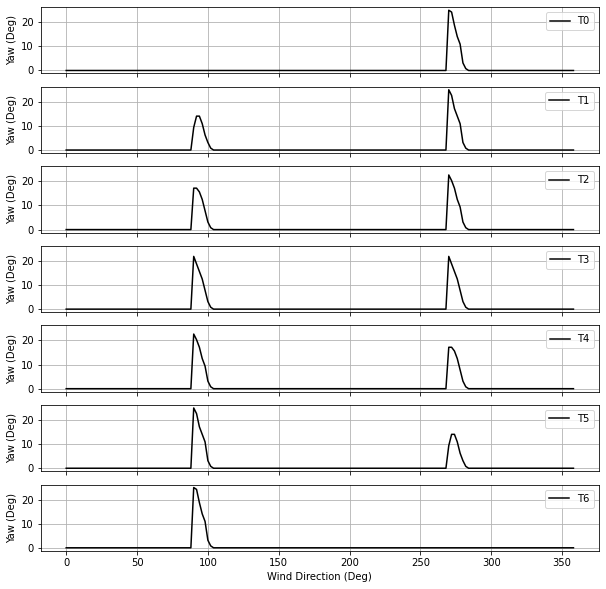

In [25]:
# Show the results
yaw_angles_opt = np.vstack(df_opt["yaw_angles_opt"])
fig, axarr = plt.subplots(len(X), 1, sharex=True, sharey=True, figsize=(10, 10))
for i in range(len(X)):
    axarr[i].plot(wind_directions, yaw_angles_opt[:, i], 'k-', label='T%d' % i)
    axarr[i].set_ylabel('Yaw (Deg)')
    axarr[i].legend()
    axarr[i].grid(True)
axarr[-1].set_xlabel('Wind Direction (Deg)')